<a href="https://colab.research.google.com/github/akalinow/Modern_Particle_Physics_Experiments/blob/2022_2023/13_Machine_learning/mlhep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monte Carlo methods - part I 

## Setup the environment

In [24]:
#Color printing
from termcolor import colored

#General data operations library
import math
import numpy as np
import pandas as pd

#HEP specific tools
import scipy.constants as scipy_constants
from particle import Particle

#Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Metrics
from sklearn.metrics import accuracy_score

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

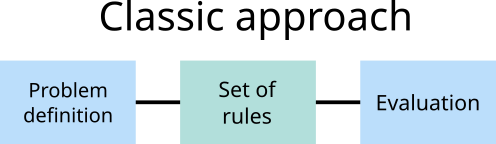

In classic approach we know our task is to distinguish particles produced in an experiment. We start thinking how can we do this, eg. what particles will we observed, maybe we can calculate their masses or charges from the values we can reconstruct from our data, how can we obtain physical parameters from our data. So from our understanding of the problem we prepare a very concrete set of rules, ussually called "selection cuts".

# What is machine learning (ML)?

*\[Machine learning is a\] field of study that gives computers the ability to learn without being explicitly programmed.*

Arthur Samuel, **1959**

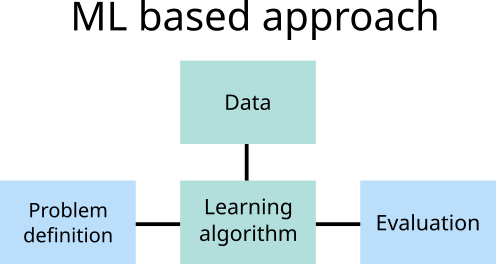

In machine learning based approach instead of constructing a set of rules we will use the data we have to train a model. We don't have to know exactly which physical values we need to construct, if the information is in our data we will let the model learn how to extract it efficiently. This doesn't mean we don't have to understand our problem! If we know that some variables will be useful we can calculate and add them to the dataset to make our model more efficient.

Surprisingly the choice of a specific model is a secondary problem. Most of time the data is more crucial that the model itself. Usually with very good dataset you can achieve good results even with poorly chosen model, but even with the best model we will not score high if the data is garbage.

<img src="https://www.smbc-comics.com/comics/1538492931-20181002.png" alt="https://www.smbc-comics.com/comics/1538492931-20181002.png" width="600"/>

### Machine learning in HEP

- **Analysis:**
    - classifying signal and background,
    - reconstructing heavy particles and improving energy resolution.
- **Event reconstruction:**
    - track reconstruction,
    - particle identification.
- **Trigger:**
    - quick final state estimation.
- **Simulation:**
    - generating realistic electronic effects,
    - faster than Monte Carlo event generation.
- **Detector control (called slow control):**
    - early fault state prediction.
- **Computing:**
    - estimating dataset popularity, determining needed number of replicas.

## Machine Learning in a nutshell

Any Machine Learning (ML) model makes an attempt to construct a function from
the `n` dimensional input space (`features`) to the ``m`` dimensional output space (`targets` or `labels`):

$$\Huge{
R^{n} \rightarrow R^{m}
}
$$

Basing on the output data there are four main flavours of ML models:

* according to the type of the output space:
    * **regression** - the output space is the ussual $R^{m}$
    * **categorisation** - the output space is a discrete set of possibilities - ``categories``. The model is expected to provide probability that example ``x`` belongs to class ``y``.  
* according to the avalaibility of the data in the output space - ``labels``:
    * **supervised learning** - a full set of input: ``X``, and output: ``Y`` values is available: ``data=(X,Y)``
    * **unsupervised learing** - only the input data: ``X`` is avalable. ``Y`` values are usually unknown: ``data=(X)``

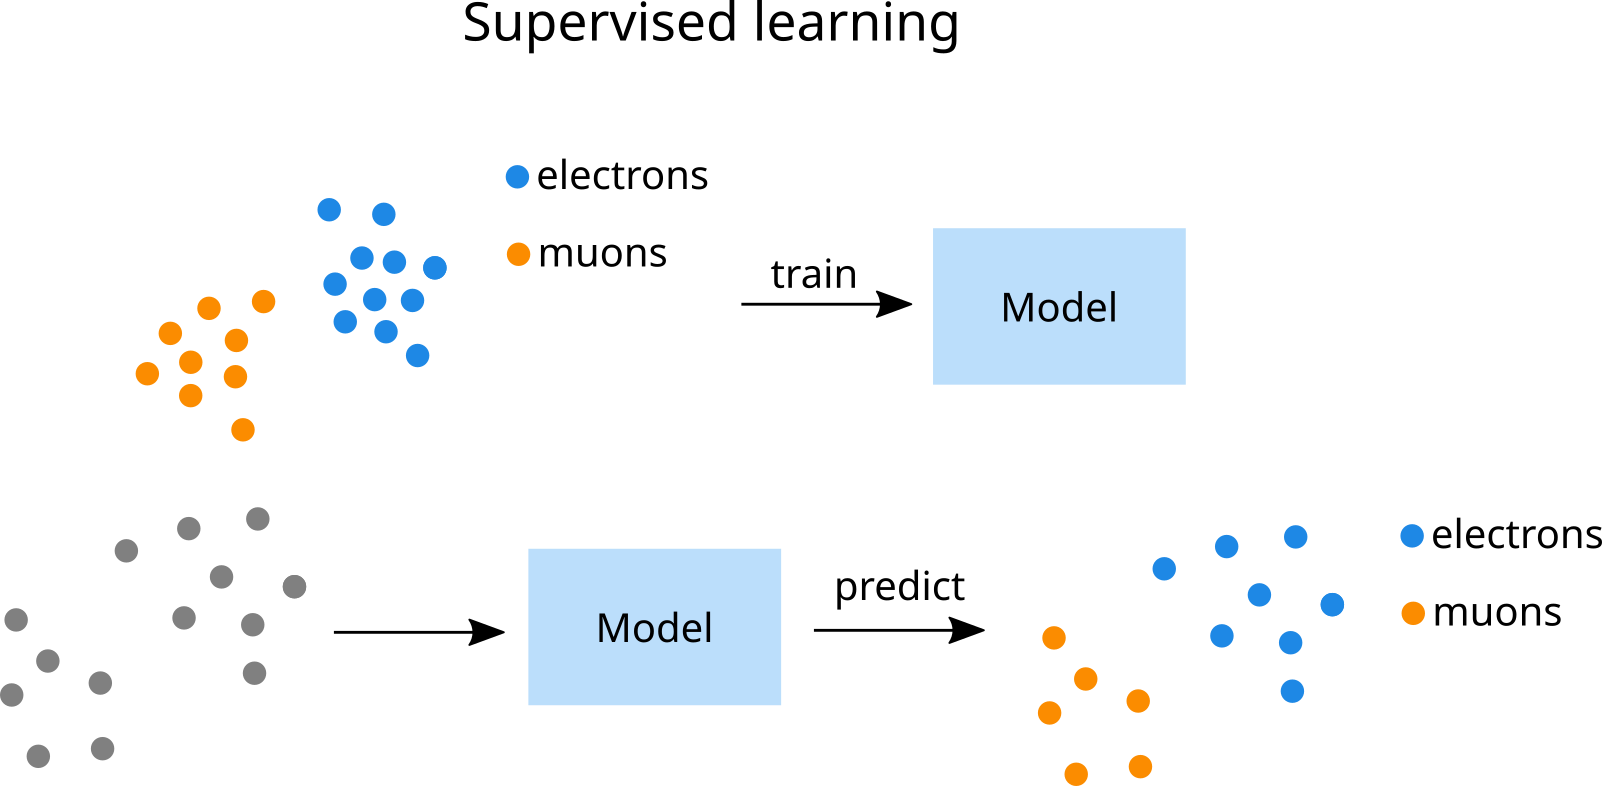

Supervised learning uses labeled datasets to train algorithms for classifying data or predicting outcomes accurately. As input data is fed into the model, it adjusts its weights until the model has been fitted appropriately.

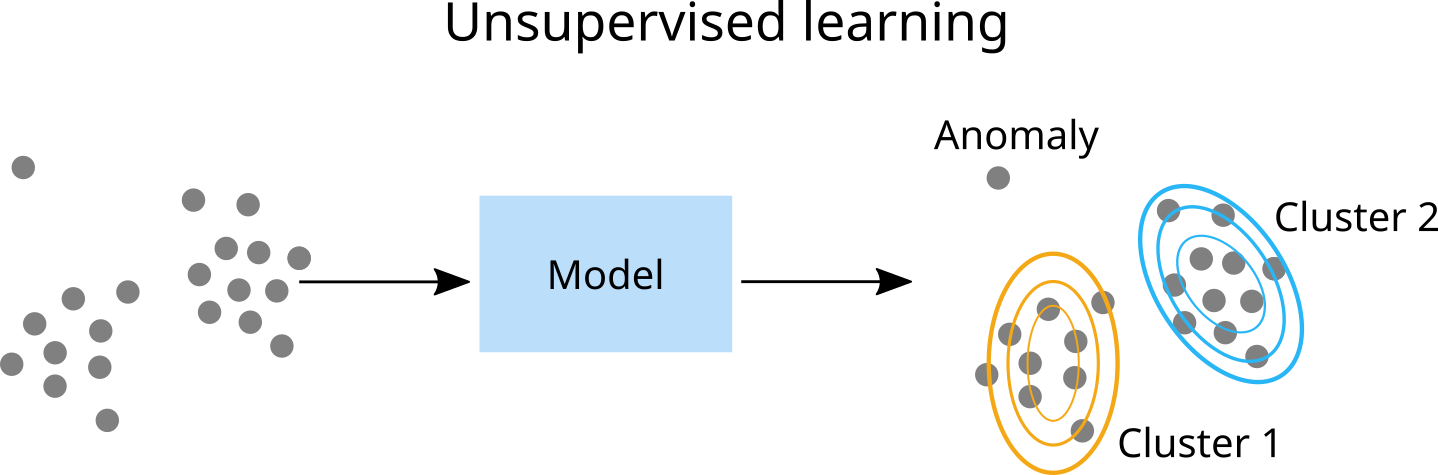

Unsupervised learning uses machine learning algorithms to discover patterns hidden in unlabeled datasets. The algorithms are able to analyze and find clusters or anomalies without the need for any input from experts.

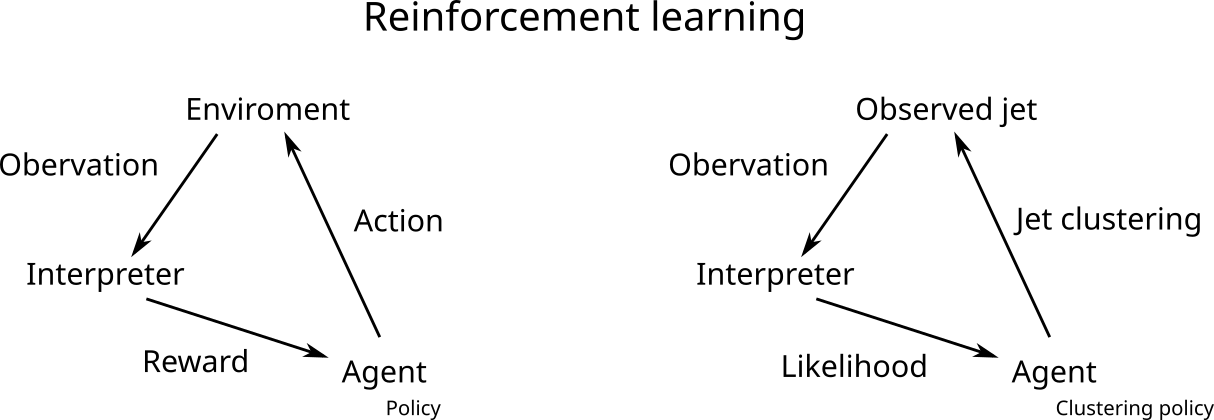

In reinforcement machine learning the algorithm isn’t trained using sample data, instead it learns by trial and error. A sequence of successful outcomes will be reinforced to develop the best recommendation or policy for a given problem.

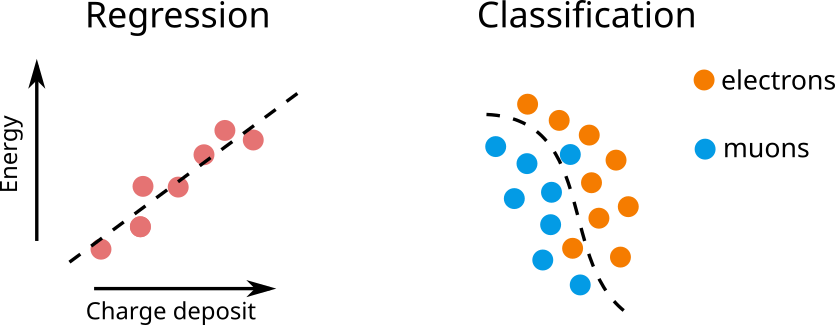

🤔 Is our problem a regression or classification?

🙋

### Types of classification:

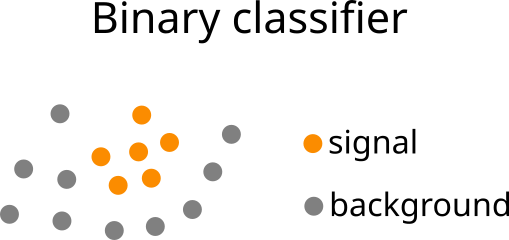

Samples belong to either one of two classes usually called `True` and `False` or `background` and `signal`.

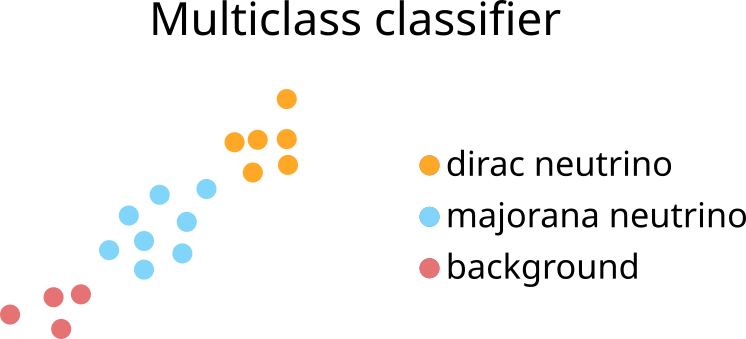

### Training: a loss function

We find the estimates of our model parameters as those which provide a model that minimizes a **loss function:**

$$
\huge{
L(f(X), Y)
}
$$

Most popular loss functions:

* **regression task:** mean squared error (MSE):

$$
\huge{
L(f(X), Y) = \frac{1}{N} \sum_{X} (f(x) - y)^{2}
}
$$

where `N` in the size of the dataset (X,Y). We **never** use all the data points at hand here! ``X`` is a sub sample - a **training** set. 
Well, never, unless we can have infinite amount of data - as in our case, where we can always generate more data.

* **categorisation task:** cross entropy or likelihood:

$$
\huge{
L(f(X), Y) = -\log P_{model}(Y|X) = \\ 
-\sum_{X} \log f_{correct~class}(x)
}
$$

**Notes**: 

* sometimes a $\frac{1}{N}$ normalising factor is included. It is not important for the training, but important if one wants to compare the loss value for samples of different size.

* model provides probability that example belongs to class ``i``: $f(x) = (p_{0}(x), p_{1}(x),...p_{m-1}(x))$ (note here f(x) is a vector, with rank `m` - equal to number of classes). We select only the component corresponding to the correct class.

Samples belong to any number of two or more classes. Again, some algorithms can be adapted for multilabel classification otherwise the problem can be transformed to multiple  binary or multiclass problems.


# Classification example

[Dataset from the ATLAS Higgs Boson Machine Learning Challenge 2014](https://opendata.cern.ch/record/328)

The dataset has been built from official ATLAS full-detector simulation of $pp$ collisions and contains a mixture of events:
- $H \rightarrow \tau\tau$, $\leftarrow$ signal
- $Z \rightarrow \tau\tau$, 
- $Z \rightarrow tt$
- $W \rightarrow e\tau$ or $\mu\tau$.

Each every event following variables are provided:
- **DER_mass_MMC** -	The estimated mass of the Higgs boson candidate, obtained through a probabilistic phase space integration.
- **DER_mass_transverse_met_lep** -	The transverse mass between the missing transverse energy and the lepton.
- **DER_mass_vis** -	The invariant mass of the hadronic tau and the lepton.
- **DER_pt_h** -	The modulus of the vector sum of the transverse momentum of the hadronic tau, the lepton and the missing transverse energy vector.
- **DER_deltaeta_jet_jet** -	The absolute value of the pseudorapidity separation between the two jets (undefined if PRI_jet_num ≤1).
- **DER_mass_jet_jet** -	The invariant mass of the two jets (undefined if PRI_jet_num ≤1).
- **DER_prodeta_jet_jet** -	The product of the pseudorapidities of the two jets (undefined if PRI_jet_num ≤1).
- **DER_deltar_tau_lep** -	The R separation between the hadronic tau and the lepton.
- **DER_pt_tot** -	The modulus of the vector sum of the missing transverse momenta and the transverse momenta of the hadronic tau, the lepton, the leading jet (if PRI_jet_num ≥1) and the subleading jet (if PRI jet num = 2) (but not of any additional jets).
- **DER_sum_pt** -	The sum of the moduli of the transverse momenta of the hadronic tau, the lepton, the leading jet (if PRI jet num ≥1) and the subleading jet (if PRI jet num = 2) and the other jets (if PRI jet num = 3).
- **DER_pt_ratio_lep_tau** -	The ratio of the transverse momenta of the lepton and the hadronic tau.
- **DER_met_phi_centrality** -	The centrality of the azimuthal angle of the missing transverse energy vector w.r.t. the hadronic tau and the lepton.
- **DER_lep_eta_centrality** - The centrality of the pseudorapidity of the lepton w.r.t. the two jets (undefined if PRI_jet_num ≤1).
- **PRI_tau_pt** -	The transverse momentum $\sqrt{p^{2}_{x}+p^{2}_{y}}$ of the hadronic tau.
- **PRI_tau_eta** -	The pseudorapidity η of the hadronic tau.
- **PRI_tau_phi** -	The azimuth angle ϕ of the hadronic tau.
- **PRI_lep_pt** 	- The transverse momentum $\sqrt{p^{2}_{x}+p^{2}_{y}}$ of the lepton (electron or muon).
- **PRI_lep_eta** -	The pseudorapidity η of the lepton.
- **PRI_lep_phi** -	The azimuth angle ϕ of the lepton.
- **PRI_met** -	The missing transverse energy $\vec{E}^{miss}_{T}$
- **PRI_met_phi** -	The azimuth angle ϕ of the mssing transverse energy
- **PRI_met_sumet** -	The total transverse energy in the detector.
- **PRI_jet_num** -	The number of jets (integer with value of 0, 1, 2 or 3; possible larger values have been capped at 3).
- **PRI_jet_leading_pt** -	The transverse momentum $\sqrt{p^{2}_{x}+p^{2}_{y}}$ of the leading jet, that is the jet with largest transverse momentum (undefined if PRI_jet_num = 0).
- **PRI_jet_leading_eta** -	The pseudorapidity η of the leading jet (undefined if PRI jet num = 0).
- **PRI_jet_leading_phi** -	The azimuth angle ϕ of the leading jet (undefined if PRI jet num = 0).
- **PRI_jet_subleading_pt** -	The transverse momentum $\sqrt{p^{2}_{x}+p^{2}_{y}}$ of the leading jet, that is, the jet with second largest transverse momentum (undefined if PRI_jet_num ≤1).
- **PRI_jet_subleading_eta** -	The pseudorapidity η of the subleading jet (undefined if PRI_jet_num ≤ 1).
- **PRI_jet_subleading_phi** -	The azimuth angle ϕ of the subleading jet (undefined if PRI_jet_num ≤ 1).
- **PRI_jet_all_pt** - 	The scalar sum of the transverse momentum of all the jets of the events.
- **Weight** 	- The event weight
- **Label** -	The event label (string) ∈ {s,b} (s for signal, b for background).
- **KaggleSet** -	String specifying to which Kaggle set the event belongs : ”t”:training, ”b”:public leaderboard, ”v”:private leaderboard,”u”:unused.
- **KaggleWeigh**t -	Weight normalised within each Kaggle dataset.

**Our task is to build a classifier that will be able to select the $H \rightarrow \tau\tau$ events from the background.**

First we need to download the dataset. Like many other datasets from CERN our dataset is hosted on [opendata.cern.ch](https://open.data.cern.ch).

Now, we need to load the dataset and check what's inside.

To represent our data inside the code we will use the `pandas` library. `pandas` is built on top of `numpy` and is very convenient for data analysis and manipulation. For us the most interesting part of the library will be `pandas.Dataframe`. Dataframes are extremely popular data structure that models data as 2D  table (like spreadsheet) with columns (variables) and rows (entries). 

Teaching `pandas` is not in the scope of this notebook. Most methods should be more or less understandable or explained in the [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html)

FYI current versions of `ROOT` have `ROOT.RDataFrame` which is more modern dataframe interface for classic `ROOT.Tree` and other formats. Check [manual](https://root.cern/manual/data_frame/) 😉.

In [2]:
filePath = 'https://opendata.cern.ch/record/328/files/atlas-higgs-challenge-2014-v2.csv.gz'
filePath = 'https://akalinow.web.cern.ch/akalinow/HiggsBoson_ML_challenge/atlas-higgs-challenge-2014-v2.csv.gz'

df = pd.read_csv(filePath)

Print information about the dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818238 entries, 0 to 818237
Data columns (total 35 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   EventId                      818238 non-null  int64  
 1   DER_mass_MMC                 818238 non-null  float64
 2   DER_mass_transverse_met_lep  818238 non-null  float64
 3   DER_mass_vis                 818238 non-null  float64
 4   DER_pt_h                     818238 non-null  float64
 5   DER_deltaeta_jet_jet         818238 non-null  float64
 6   DER_mass_jet_jet             818238 non-null  float64
 7   DER_prodeta_jet_jet          818238 non-null  float64
 8   DER_deltar_tau_lep           818238 non-null  float64
 9   DER_pt_tot                   818238 non-null  float64
 10  DER_sum_pt                   818238 non-null  float64
 11  DER_pt_ratio_lep_tau         818238 non-null  float64
 12  DER_met_phi_centrality       818238 non-null  float64
 13 

Our data set is quite big. It will be faster to make calculations and plots for smaller sample

In [4]:
df=df.sample(n=10000, random_state=1)

Print a list of column names in dataset.

In [5]:
df.columns

Index(['EventId', 'DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt',
       'Weight', 'Label', 'KaggleSet', 'KaggleWeight'],
      dtype='object')

Let's remove columns we won't use

In [6]:
df.drop(columns = ['KaggleSet','KaggleWeight','Weight', 'EventId'], inplace = True)

Let's check what is the mysterious `object` in `Label` column.

In [7]:
df['Label']

755442    b
689730    b
357609    s
584061    s
485493    s
         ..
425572    b
724919    s
633005    b
5289      b
126956    b
Name: Label, Length: 10000, dtype: object

The algorithm we will use requires numerical values not strings. We need to encode the classes.
It is a bit more convenient ot use int instead of bool type.

In [8]:
df['Label'] = df['Label']=='s'
df['Label'] = df['Label'].astype(int)
df['Label']

755442    0
689730    0
357609    1
584061    1
485493    1
         ..
425572    0
724919    1
633005    0
5289      0
126956    0
Name: Label, Length: 10000, dtype: int64

Now we should be left only with interesting data. Let's take another look

In [9]:
df.head(5).T

,755442,689730,357609,584061,485493
DER_mass_MMC,96.278,70.984,116.945,128.609,129.960
DER_mass_transverse_met_lep,52.798,51.882,19.162,51.812,81.204
DER_mass_vis,66.239,54.936,79.868,78.701,83.901
DER_pt_h,4.500,9.215,144.923,209.987,62.030
DER_deltaeta_jet_jet,-999.000,-999.000,-999.000,1.413,-999.000
DER_mass_jet_jet,-999.000,-999.000,-999.000,290.661,-999.000
DER_prodeta_jet_jet,-999.000,-999.000,-999.000,-0.262,-999.000
DER_deltar_tau_lep,3.117,2.317,1.495,1.432,3.096
DER_pt_tot,4.500,54.293,28.391,90.460,41.568
DER_sum_pt,66.204,115.236,252.455,399.141,109.597


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
DER_mass_MMC,10000.0,-46.130196,405.559669,-999.000,79.20925,105.6375,131.41575,883.288
DER_mass_transverse_met_lep,10000.0,49.205520,34.979383,0.006,19.55425,46.1000,73.47775,302.758
DER_mass_vis,10000.0,82.123675,43.034755,10.428,59.74050,73.9995,92.56725,1051.358
DER_pt_h,10000.0,58.975879,64.193888,0.000,14.57050,39.0195,80.79600,736.408
DER_deltaeta_jet_jet,10000.0,-703.275890,456.856500,-999.000,-999.00000,-999.0000,0.53600,7.840
DER_mass_jet_jet,10000.0,-591.602669,664.977815,-999.000,-999.00000,-999.0000,88.86850,3520.179
DER_prodeta_jet_jet,10000.0,-704.260725,455.338246,-999.000,-999.00000,-999.0000,-4.38700,14.717
DER_deltar_tau_lep,10000.0,2.378342,0.783085,0.397,1.82500,2.4995,2.96200,5.535
DER_pt_tot,10000.0,19.303920,22.694977,0.000,2.86375,12.4420,27.69925,372.721
DER_sum_pt,10000.0,161.882559,119.359137,46.104,77.93750,122.7280,206.43600,1852.462


Histogram of all the variables present in the dataset (a plot is worth 1000 words).

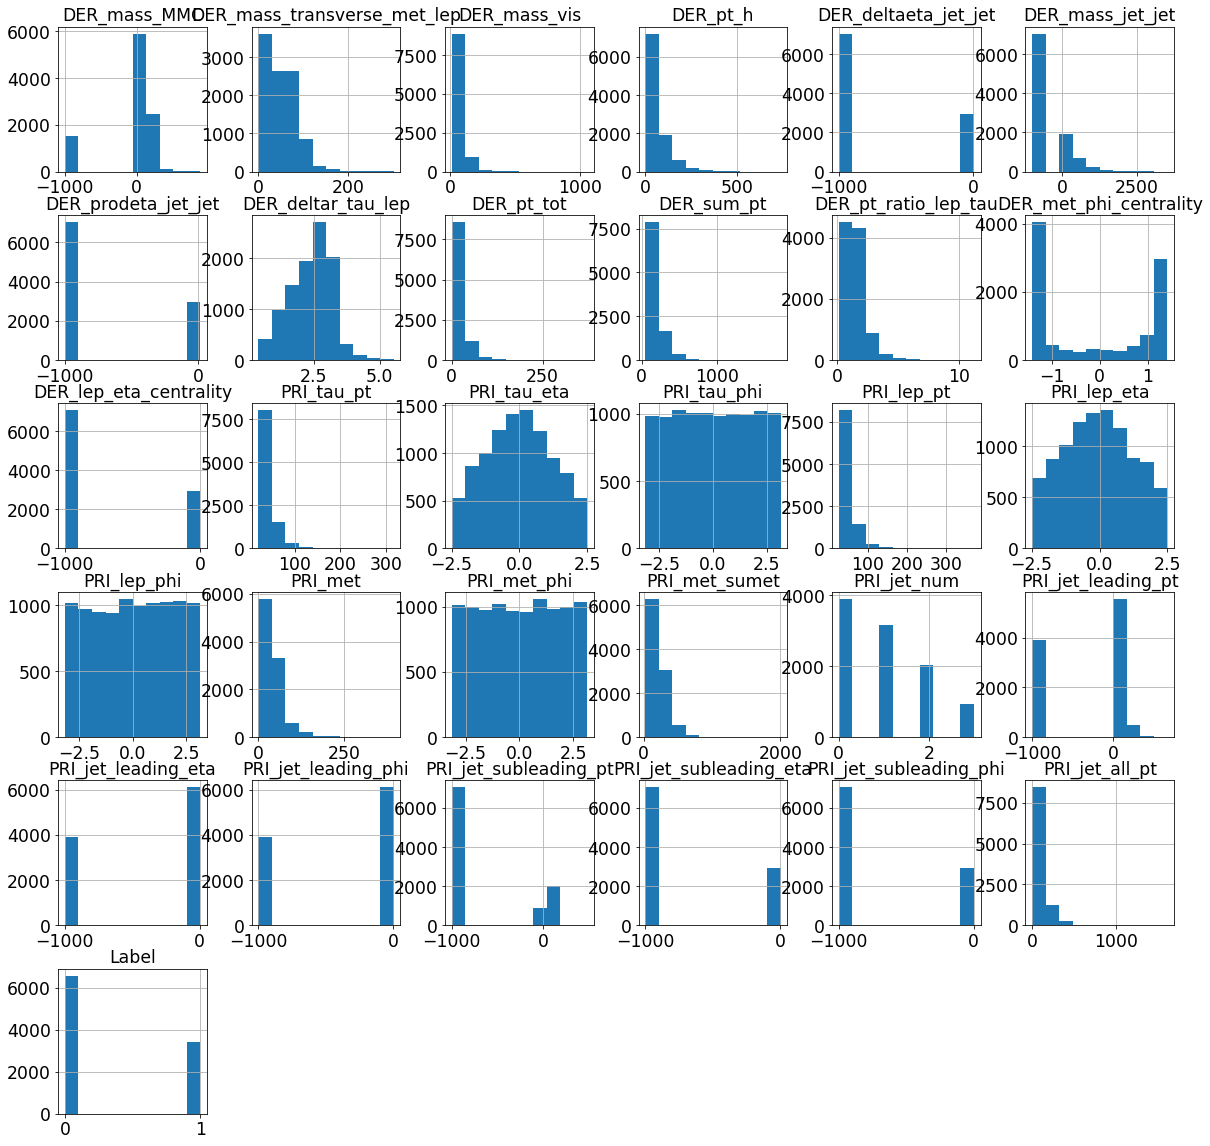

In [11]:
df.hist(figsize=(20,20));

Since our problem is classifying the event it may be worth to plot the distribution splitted by classes.
To do this we will use yet another library you may not know. `seaborn` is a popular plotting library built on top of `matplotlib` that plays very nicely with `pandas`. Check the [documentation](https://seaborn.pydata.org/introduction.html) if you are interested.

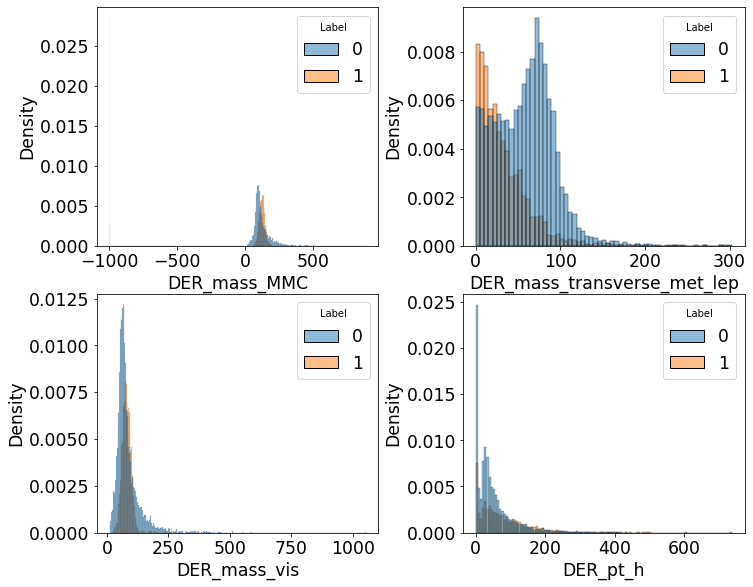

In [225]:
columns = ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis','DER_pt_h']
    
fig, axes = plt.subplots(2,2, figsize=(10,10))

for item in enumerate(axes.flatten()):
    index = item[0]
    axis = item[1]
    sns.histplot(data=df, x=columns[index], hue='Label', stat='density', ax=axis);
    
plt.subplots_adjust(bottom=0.15, left=0.05, right=0.95, wspace=0.3)      

**Please:**

* improve the plots visibilty by adjusting the axes limits
* make a 3x3 plot with nine variables: 

```Python
'DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 
'DER_pt_h','DER_deltar_tau_lep', 'DER_pt_tot', 
'PRI_met', 'PRI_tau_pt','PRI_lep_pt'
```


**Hint:** 
* use 'bins` parameter of the `sns.histplotsns.histplot` function
* you can set the limits by hand, or using some quantile of the variable distribution:
```Python
minX = df1[columns[index]].quantile(0.05)
maxX = df1[columns[index]].quantile(0.95)
```

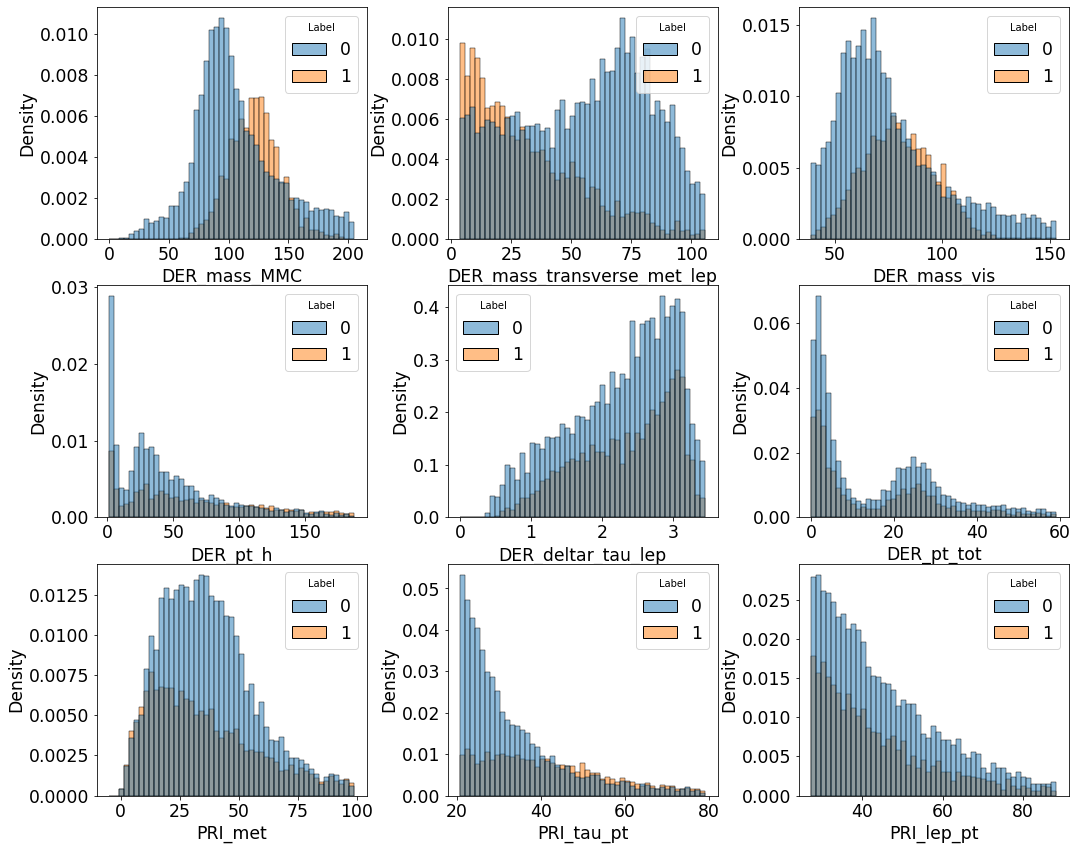

In [223]:
...
pass

It is important to see what are the correlations between variables in particular classes. Here we plot two variable correlations splitted into classes.

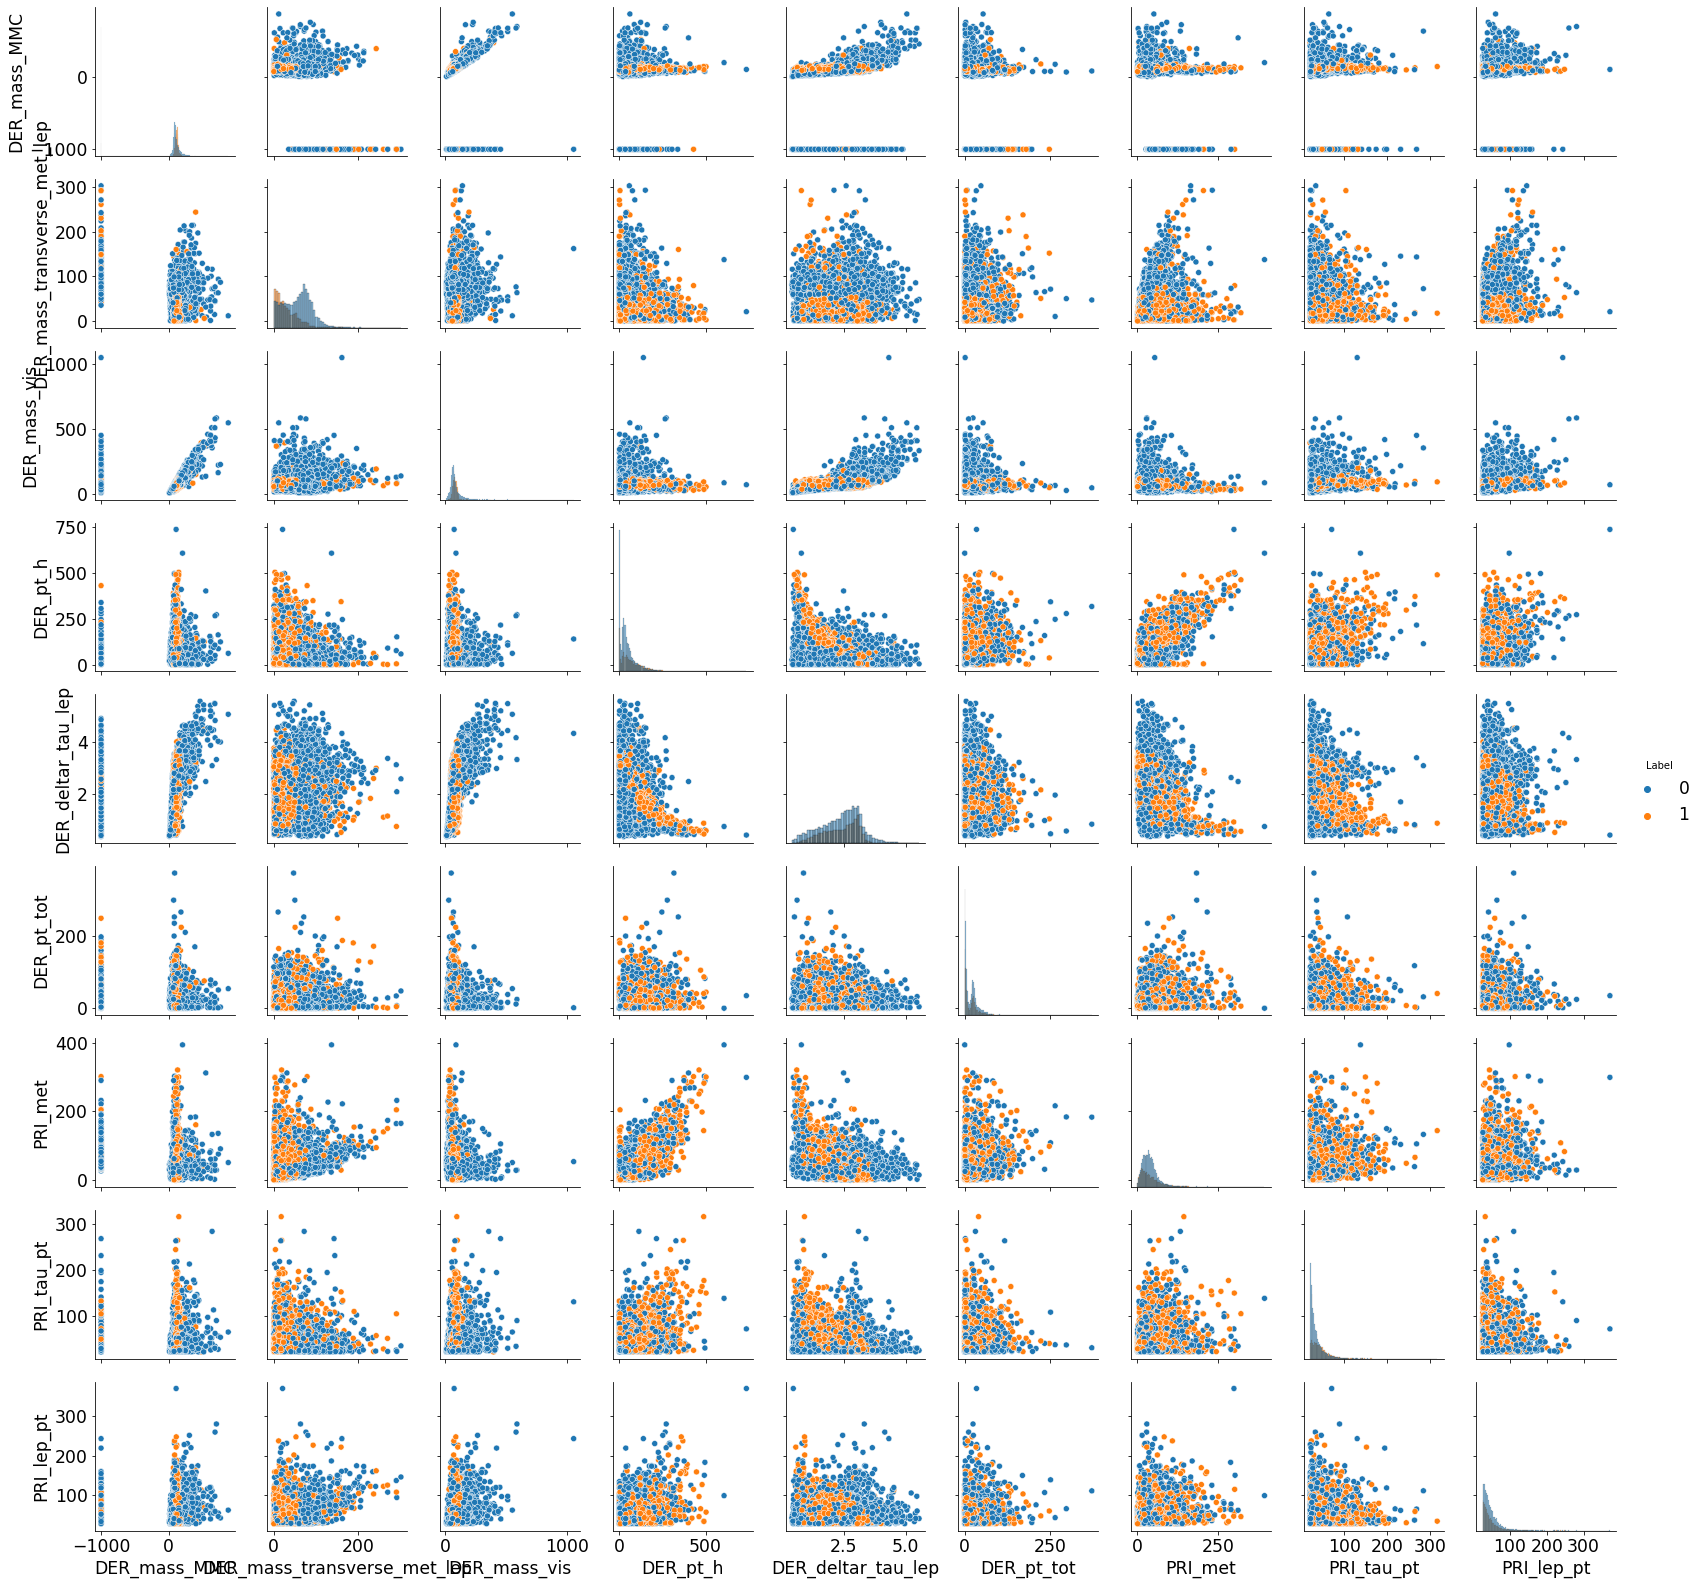

In [16]:
graph = sns.PairGrid(df, vars=columns, hue="Label")
graph.map_diag(sns.histplot)
graph.map_offdiag(sns.scatterplot);
graph.add_legend();

Before we start training our model we have to spli the data into training and testing subsets.

- **train subset** - used for training our model, 
- **test subset** - used for evaluating our model.

By keeping the test subset separated, we can use it to estimate how the model will behave on real data (unlabeled). We will use methods from sklearn library to split the data into given proportions.

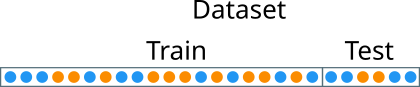

In [132]:
from sklearn.model_selection import train_test_split

#Split data into trains and test sets
df_train, df_test = train_test_split(df, test_size = 0.2, random_state=42)

#Save the labels columns
y_train = df_train['Label']
y_test = df_test['Label']

#Remove the labels columns from features
df_train.drop(columns=['Label'], inplace=True)
df_test.drop(columns=['Label'], inplace=True)

print(colored("Train labels shape:","blue"), y_train.shape)
print(colored("Test labels shape:","blue"), y_test.shape)

print(colored("Train features shape:","blue"), df_train.shape)
print(colored("Test features shape:","blue"), df_test.shape)

Train labels shape: (8000,)
Test labels shape: (2000,)
Train features shape: (8000, 30)
Test features shape: (2000, 30)


On previous plots we've noticed that the variables can have different order of magnitudes. For our algorithm it'd be best if every variable was of the same order. To achieve this we need to rescale them

## The training

Now that our dataset has been preprocessed we can finally start training our model. 

As a first model we will use a random number for separation.

**Please:**

* create a model that returns a random class
* fill the `y_pred` with model answer


In [91]:
...

## Model performance on training data

It can happend that out model makes a few mistakes. We need to somehow evaluate it's results and looking at every event is not an option.

Let's introduce **accuracy** metric:

$
\Large{
\text{Accuracy}=\frac{\text{Number of correct predictions}}{\text{Total number 
of predictions}}
}
$

and calculate it on the test dataset. 

**What value of the metric we expect with our model?**

In [93]:
acc= accuracy_score(y_test, y_pred)
print(colored('Test set: accuracy score','blue'), acc)

Test set: accuracy score 0.488


Is this good? Is accuracy a good metric?

**Please**

* create a model that always assign event to background (Label=0) class
* fill the y_pred with model predictions
* calculate the acciracy

**What value of the metric we expect with our model?**

In [94]:
...

Test set: accuracy score 0.646


## Homework


Please create a more meaningfull model for signal background separation:

* find a pair of variables $(v1, v2)$ that look most separating 
* create a linear (it can be a set of lines) model that will separate the signal and background on the $(v1, v2)$ plane:

$$
\Large{
f(v1, v2) >0 \rightarrow \text{signal} \\
f(v1, v2) <=0 \rightarrow \text{background}
}
$$

* calculate the accuracy for this model, and compare it to the best model found today.

**Note:** to get positive mark you have to find a model that given better accuracy at lest 0.7.

In [ ]:
...

## References and materials



- [scikit-learn](https://scikit-learn.org/stable/user_guide.html) - package documentation,
- [HEP-ML-Resources](https://github.com/iml-wg/HEP-ML-Resources) - git repository with collection of links to courses, classes, slides, papers, etc. about ML in HEP,
- [openddata.cern.ch](http://opendata.cern.ch/) - datasets and resources from CERN,
- [kaggle](https://www.kaggle.com) - dataset and challenges for ML,
- [usosweb](https://usosweb.fuw.edu.pl/kontroler.php?_action=katalog2/przedmioty/pokazPrzedmiot&prz_kod=1100-3BN17&callback=g_090c7e64) - a ML course at FUW,
- Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems, Aurélien Géron - a book about ML I particulary like